<a href="https://colab.research.google.com/github/yonatanlou/study_projects/blob/main/Statistics_lab/labs/Lab8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import modules 
import numpy as np
import pandas as pd 
from scipy.spatial.distance import mahalanobis
import scipy as sp

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.style.use('bmh')

from functools import partialmethod
pd.DataFrame.head = partialmethod(pd.DataFrame.head, n=10)
pd.options.display.float_format = "{:,.4f}".format
pd.get_option("display.max_columns")

import random
random.seed(42)

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display

### Notes about running this code



1.   Each Question will be in its own caluse. Every question is independent from the others. That is running a question cells should be working correctly independently from other.
2.   There are some common varaibles that are shared across the Lab. All of them are listed inside the Global Data code. <b>Global Data</b> cells should run before attempting any of the questions.
3. All shared functions are declraed in the <b>Functions</b> clause where an in depth description is provided for each.
4. The variables naming in each question can be shared. For example, df varaible will be used accross al question to define the relevant data frame. This is on purpose and should make the notebook more readble. As we said, each question is independet from the others.


## Global Data

In [ ]:
data_ballot_2021 = "https://raw.githubusercontent.com/yonatanlou/study_projects/main/Statistics_lab/votes_per_ballot_2021.csv"
data_ballot_2020 = "https://raw.githubusercontent.com/yonatanlou/study_projects/main/Statistics_lab/votes_per_ballot_2020.csv"
ballot_2021 = pd.read_csv(data_ballot_2021,  encoding = 'iso-8859-8', index_col='שם ישוב')
ballot_2020 = pd.read_csv(data_ballot_2020,  encoding = 'iso-8859-8', index_col='שם ישוב')


ballot_2021 = ballot_2021.iloc[:,:-1]
ballot_2020 = ballot_2020.iloc[:,:-1]
ballot_2021 = ballot_2021.loc[~ballot_2021.index.str.fullmatch('מעטפות חיצוניות')]
ballot_2020 = ballot_2020.loc[~ballot_2020.index.str.fullmatch('מעטפות חיצוניות')]

parties_dict ={'אמת' : "עבודה", 'מרצ' : "מרצ",  'ג' : "יהדות התורה", 'עם'  : "רעם",  'ת'  : "תקוה חדשה", 'ודעם'  : "הרשימה המשותפת", 'ב'  : "ימינה", 'ט'  : "הציונות הדתית",
 'ל'  : "ישראל ביתנו", 'מחל'  : "הליכוד",  'פה'  : "יש עתיד", 'כן'  : "כחול לבן", 'שס'  : "שס"}


In [ ]:
## Proccessing 2020 data 
ballot_2020_proccesed = ballot_2020.copy()
ballot_2020_proccesed['אמת'] = ballot_2020.loc[:,'אמת']/2
ballot_2020_proccesed['מרצ'] = ballot_2020.loc[:,'אמת']/2
ballot_2020_proccesed['עם'] = ballot_2020.loc[:,'ודעם']*0.4
ballot_2020_proccesed['ודעם'] = ballot_2020.loc[:,'ודעם']*0.6
ballot_2020_proccesed['ת'] = ballot_2020.loc[:,'מחל']/6
ballot_2020_proccesed['מחל'] = ballot_2020.loc[:,'מחל']*5/6
ballot_2020_proccesed['כן'] = ballot_2020.loc[:,'פה']/3
ballot_2020_proccesed['פה'] = ballot_2020.loc[:,'פה']*2/3
ballot_2020_proccesed['ב'] = ballot_2020.loc[:,'טב']*0.6
ballot_2020_proccesed['ט']= ballot_2020.loc[:,'טב']*0.4 + ballot_2020.loc[:,'נץ']

ballot_2020_proccesed = ballot_2020_proccesed.drop([ 'נץ','טב'], axis=1) ## Dropping parties that are already ditributed among others above.

In [ ]:
## Reading Eco data to be used in Q2
eshkol_df = pd.read_excel("https://raw.githubusercontent.com/yonatanlou/study_projects/main/Statistics_lab/eshkol_hevrati_calcali.xlsx")
eshkol_df.set_index("set_code", inplace=True)
eco_df = eshkol_df[["eco_level"]]
eco_df["eco_level"] = eco_df["eco_level"].astype(int)

ballot_df_with_eco = ballot_2021.join(eshkol_df, on="סמל ישוב") 

## Functions


### Genreic

In [ ]:
def parties_votes_percents(df, thresh):
  """
  df : DataFrame - each row is either ballot or city, columns are the parties.
  thresh: float - the threshold for which we would filter the data frame.
  return : New data frame that contains (as columns) only 
  parties with voting ratio higher than thresh
  """
  par = df.sum().div(df.sum().sum()).sort_values(ascending=False)
  return par[par >= thresh]



### Plotting

In [ ]:
def create_simulation_bar_plot(sim_df, title):
  """
    sim_df: data frame with these column 
    party	p_real	p_hat	p_hat_bias	p_hat_sd	p_hat_mse
    title: str - desired plot title
  """
  p_real = sim_df.p_real.values
  p_hat = sim_df.p_hat
  p_hat_sd = sim_df.p_hat_sd
  parties = sim_df.party
  WIDTH = 0.4
  fig, ax = plt.subplots(figsize=(16,8))
  ax.grid(False)
  for s in ["right", "top"]:
      ax.spines[s].set_visible(False)
  fig.set_facecolor("#fefcf5")
  ax.set_facecolor("#fefcf5")
  x = np.arange(len(parties))
  ax.bar(x, p_real, WIDTH, alpha=0.7, color="#906297", label="Real Voting Percent")
  ax.bar(x+WIDTH*1.1, p_hat, WIDTH, alpha=0.7, color="#FEA957", yerr=p_hat_sd, ecolor="#D291BC", capsize=5,label="Estimated Voting Percnet")
  ax.legend()
  ax.set_xticks(x+WIDTH/2)  
  ax.set_xticklabels(["\n".join(parties_dict[i][::-1].split(" ")[::-1]) for i in parties], fontsize=14)
  ax.set_ylabel('', fontsize=12)
  x0, x1 = ax.get_xlim()
  y0, y1 = ax.get_ylim()
  ax.text(x0, y1*1.2, title, fontsize=20, ha='left', va='top', weight='bold')
  plt.show()

In [ ]:
def create_line_plot(ax , alpha, var, bias_sqrd, party_name, minimun_point=None):
  """
    ax: matplotlib ax object
    alpha: alpha vector 
    var : variance vector
    bias_sqrd: bias_sqrd vector
    party name: Party name string
    minimum point: alpha value for the analytical minimum. 

    return the ax
  """
  ax.grid(False)
  for s in ["right", "top", "left"]:
      ax.spines[s].set_visible(False)
  ax.set_facecolor("#fefcf5")
  ax.plot(alpha, var, alpha=0.9, color="#B22222", label="Variance")
  ax.plot(alpha, bias_sqrd, alpha=0.9, color="#DA70D6", label="Bias Squared")
  ax.plot(alpha, (var + bias_sqrd), alpha=0.9, color="#7B68EE", label="MSE")
  if minimun_point:
    mse_min_idx = (var + bias_sqrd).argmin()
    mse_min = (var + bias_sqrd).min()
    approx_mse_analytical = (var + bias_sqrd)[np.argmin((alpha - minimun_point)**2)]
    alpha_min = alpha[mse_min_idx]
    ax.plot(alpha_min, mse_min, marker="o", color="lightgreen", label="Empirical minimun", ms=7)
    ax.plot(minimun_point,approx_mse_analytical, marker="x",color="black", label="Analytical minimun", ms=7)
  x0, x1 = ax.get_xlim()
  y0, y1 = ax.get_ylim()
  ax.text(0.5, y1, parties_dict[party_name][::-1], fontsize=15, ha='left', va='top', weight='bold')
  return ax

## Q1

Sampling from 2021 ballots data. <br>
**We will use only 2021 data** hence variable names would be obviously related to this.

### a.

In [ ]:
df = ballot_2021.iloc[:, 10:]
real_p = parties_votes_percents(df, 0.0325) ## pd.Series
names = parties_votes_percents(df, 0.0325).index ## Index - bigges parties names
def random_simultaion(df,n_samples,n_simulations, parties):
  """
  df : voting dataFrame
  n_samples: number of sampled drawn each simulation run
  n_simulation: number of simulations to run
  parties: parties named which we will filter the df based on.

  returns data frame with the following column. dim(len(parties), 5)
  p_real : voting share for the whole data
  p_hat :  mean of simulation voting share for the each party
  sd : sd of simulation voting share for the each party
  p_mse = mse of simulation voting share for the each party
  """
  sim_mat = np.zeros((n_simulations, len(parties))) 
  for i in range(n_simulations):
    random_df = df.sample(n_samples)
    sim_mat[i,:] = parties_votes_percents(random_df, 0).filter(parties).values
  
  sim_df = pd.DataFrame()
  sim_df["party"] = parties
  sim_df["p_real"] = parties_votes_percents(df, 0).filter(parties).values
  sim_df["p_hat"] = sim_mat.mean(axis=0)
  sim_df["p_hat_bias"] = sim_df["p_hat"] - sim_df["p_real"]
  sim_df["p_hat_sd"] = np.sqrt(sim_mat.var(axis=0))
  sim_df["p_hat_mse"] = sim_df["p_hat_sd"]**2 + (sim_df["p_hat"] - sim_df["p_real"])**2
  return sim_df

sample_randomly_sim_df = random_simultaion(df, 7,100, names)
  
sample_randomly_sim_df.head()

,party,p_real,p_hat,p_hat_bias,p_hat_sd,p_hat_mse
0,מחל,0.2417,0.2350,-0.0067,0.0630,0.0040
1,פה,0.1394,0.1435,0.0041,0.0410,0.0017
2,שס,0.0732,0.0644,-0.0088,0.0378,0.0015
3,כן,0.0666,0.0682,0.0016,0.0190,0.0004
4,ג,0.0588,0.0470,-0.0118,0.0552,0.0032
5,אמת,0.0588,0.0625,0.0037,0.0253,0.0007
6,ב,0.0587,0.0613,0.0026,0.0258,0.0007
7,ל,0.0554,0.0554,0.0000,0.0250,0.0006
8,ודעם,0.0505,0.0575,0.0070,0.0606,0.0037
9,ט,0.0498,0.0485,-0.0012,0.0314,0.0010


We can see that the bias, as expected, is close to 0. The more samples that we will do, we will get a lower bias. 


### b.

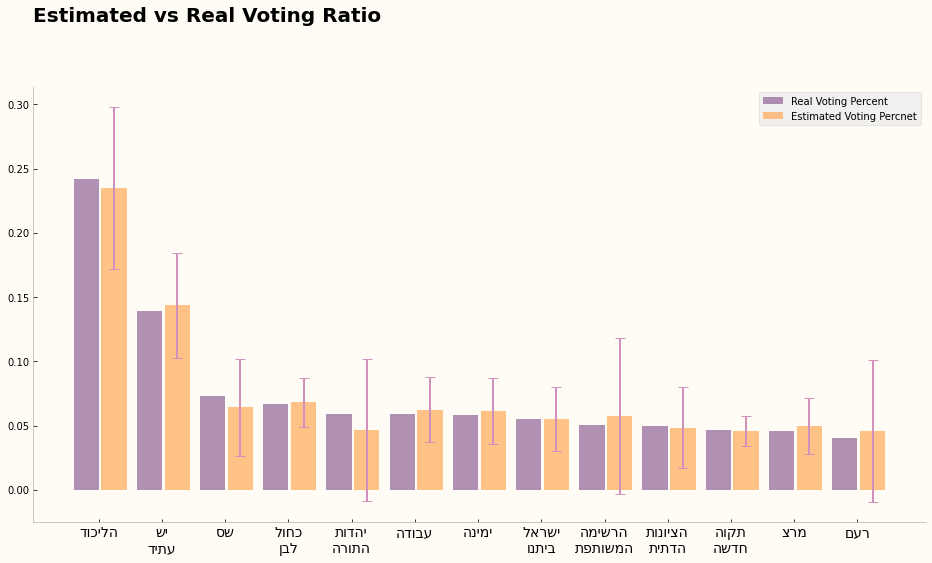

In [ ]:
create_simulation_bar_plot(sample_randomly_sim_df, "Estimated vs Real Voting Ratio")

### .c

Taken from the official election website.
https://votes24.bechirot.gov.il/nationalresults

In [ ]:
same_mandat_parties = ['ג', 'אמת', 'ל', 'ודעם', 'ט', 'ת','מרצ']
sample_randomly_sim_df.set_index("party").loc[same_mandat_parties, "p_hat_sd"]

party
ג      0.0552
אמת    0.0253
ל      0.0250
ודעם   0.0606
ט      0.0314
ת      0.0115
מרצ    0.0218
Name: p_hat_sd, dtype: float64

We can see that 57% (4/7) of the parties are with pretty similar variance (around 0.2), while ג, ודעם, and ת are with higher or lower variance.
A reasonable explanation could be that these parties voters, as seen in previous labs, are concentrated in a relativley small group of ballots. That is, their variance across ballots is really high even when "seeing" the whole data. This effect can be obviosly emphasised when using a sampling method.
Another explanation could be is that this caused by the randomness of the sample, or because of the different data of each one of the parties.


## Q2

### a.

In [ ]:
eco_vec = ballot_df_with_eco["eco_level"]

### b.

In [ ]:
df = ballot_2021.iloc[:, 10:]
df["eco"] = eco_vec
real_p = parties_votes_percents(df.iloc[:, :-1], 0.0325) ## pd.Series
names = parties_votes_percents(df.iloc[:, :-1], 0.0325).index ## Index - bigges parties names

def by_eco_simultaion(df,n_samples,n_simulations, parties):
  """
  df : voting dataFrame
  n_samples: number of sampled drawn each simulation run
  n_simulation: number of simulations to run
  parties: parties named which we will filter the df based on.

  returns data frame with the following column. dim(len(parties), 5)
  p_real : voting share for the whole data
  p_hat :  mean of simulation voting share for the each party
  sd : sd of simulation voting share for the each party
  p_mse : mse of simulation voting share for the each party
  """
  frequent_eco = df["eco"].value_counts().index[:n_samples].to_list() ## Selecting most frequent eco values in the data
  df["kosher"] = df.iloc[:,:-1].sum(axis=1)
  kosher_by_eco = df.groupby("eco").agg({"kosher":"count"})
  kosher_by_eco = (kosher_by_eco.loc[frequent_eco]/kosher_by_eco.loc[frequent_eco].sum())["kosher"]
  kosher_by_eco = kosher_by_eco.reset_index().sort_values("eco", ascending=True)["kosher"].values
  filtered_df = df[df["eco"].isin(frequent_eco)] ## filtering our df to have only ballots with certain eco levels
  sim_mat = np.zeros((n_simulations, len(parties))) ## matrix where we will be saving our results 
  for i in range(n_simulations):
    ## this sample df is always sorted bu the eco level.
    ## kosher_by_eco is also sorted
    random_df = filtered_df.groupby("eco").sample(n=1) # 1 sample from each eco level
    random_df = random_df.iloc[:,:-1]
    pj = random_df.div(random_df.sum(axis=1), axis=0).filter(parties)
    sim_mat[i:] = pj.T.values @ kosher_by_eco 

  sim_df = pd.DataFrame()
  sim_df["party"] = parties
  sim_df["p_real"] = parties_votes_percents(df.iloc[:,:-2], 0).filter(parties).values
  sim_df["p_hat"] = sim_mat.mean(axis=0)
  sim_df["p_hat_bias"] = sim_df["p_hat"] - sim_df["p_real"]
  sim_df["p_hat_sd"] = np.sqrt(sim_mat.var(axis=0))
  sim_df["p_hat_mse"] = sim_df["p_hat_sd"]**2 + (sim_df["p_hat"] - sim_df["p_real"])**2
  return sim_df


sample_by_eco_sim_df = by_eco_simultaion(df, 7,100, names)


In [ ]:
sample_by_eco_sim_df.head()

,party,p_real,p_hat,p_hat_bias,p_hat_sd,p_hat_mse
0,מחל,0.2417,0.2400,-0.0016,0.0529,0.0028
1,פה,0.1394,0.1293,-0.0102,0.0265,0.0008
2,שס,0.0732,0.0672,-0.0060,0.0314,0.0010
3,כן,0.0666,0.0617,-0.0049,0.0143,0.0002
4,ג,0.0588,0.0469,-0.0119,0.0462,0.0023
5,אמת,0.0588,0.0540,-0.0048,0.0215,0.0005
6,ב,0.0587,0.0538,-0.0049,0.0208,0.0005
7,ל,0.0554,0.0616,0.0062,0.0271,0.0008
8,ודעם,0.0505,0.0746,0.0242,0.0542,0.0035
9,ט,0.0498,0.0460,-0.0038,0.0280,0.0008


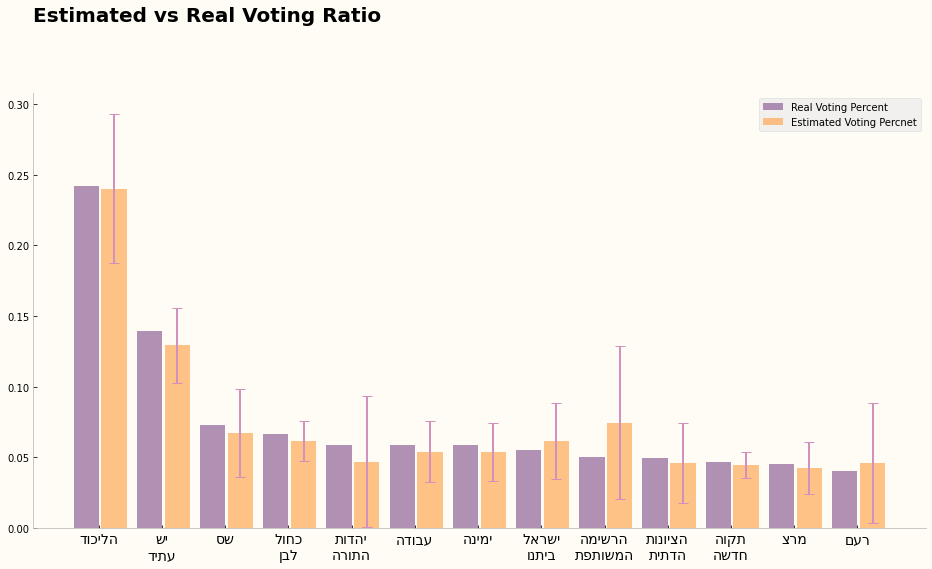

In [ ]:
create_simulation_bar_plot(sample_by_eco_sim_df, "Estimated vs Real Voting Ratio")

### c.

For this we will need data from Q1 and Q2.
I will usue the simulation data frames from both questions called <br/> **sample_randomly_sim_df** and **sample_by_eco_sim_df** equivently.

We will want to compare the sum of MSE for all parties in each question. We will then be able to decide which of the sampling methods is better in terms of minimizing the MSE.

In [ ]:
mse_q1_sum = np.sum(sample_randomly_sim_df.p_hat_mse.values)
mse_q2_sum = np.sum(sample_by_eco_sim_df.p_hat_mse.values)

print("Q1 MSE sum is {}, Q2 MSE sum is {}. Hence {} method is better than {} method in terms of minimizing the MSE". format(("%.3f"%mse_q1_sum),
                                                                                                                            ("%.3f"%mse_q2_sum),
                                                                                                                            "Q1" if mse_q1_sum < mse_q2_sum else "Q2",
                                                                                                                            "Q2" if mse_q1_sum < mse_q2_sum else "Q1"))


Q1 MSE sum is 0.021, Q2 MSE sum is 0.015. Hence Q2 method is better than Q1 method in terms of minimizing the MSE


 The MSE with the eco level sample method, led to much better results in terms of MSE (30 precent less), hence - we will probably want to use the eco level sample method instead of the ballot sample method.
 

##Q3

### a.

In [ ]:
df = ballot_2021.iloc[:, 10:]
real_p = parties_votes_percents(df, 0.0325) ## pd.Series
names = parties_votes_percents(df, 0.0325).index ## Index - bigges parties names


In [ ]:
## Extracting relevant vectors for the plotting
p_hat_var = sample_randomly_sim_df.p_hat_sd.values**2
p_hat = sample_randomly_sim_df.p_hat.values
prior_p = parties_votes_percents(ballot_2020_proccesed.iloc[:,10:],0)[names].values ## Prior p from 2020
real_p = sample_randomly_sim_df.p_real.values

In [ ]:
## The alpha weighted average function
def alpha_average(a,real_p, prior_p, p_hat, p_hat_var):
  alpha_var = a**2 * p_hat_var
  p_alpha = a*p_hat + (1-a)*prior_p
  bias_squared = (p_alpha - real_p)**2
  return  alpha_var, bias_squared

In [ ]:
bias_mat = np.zeros((101,13)) ## each column is a party, each row is alpha value
var_mat = np.zeros((101,13))

for idx , a in enumerate(np.linspace(0,1,101)):
    var, bias_squared = alpha_average(a,real_p, prior_p, p_hat, p_hat_var)
    bias_mat[idx ,:] = bias_squared
    var_mat[idx, :] = var

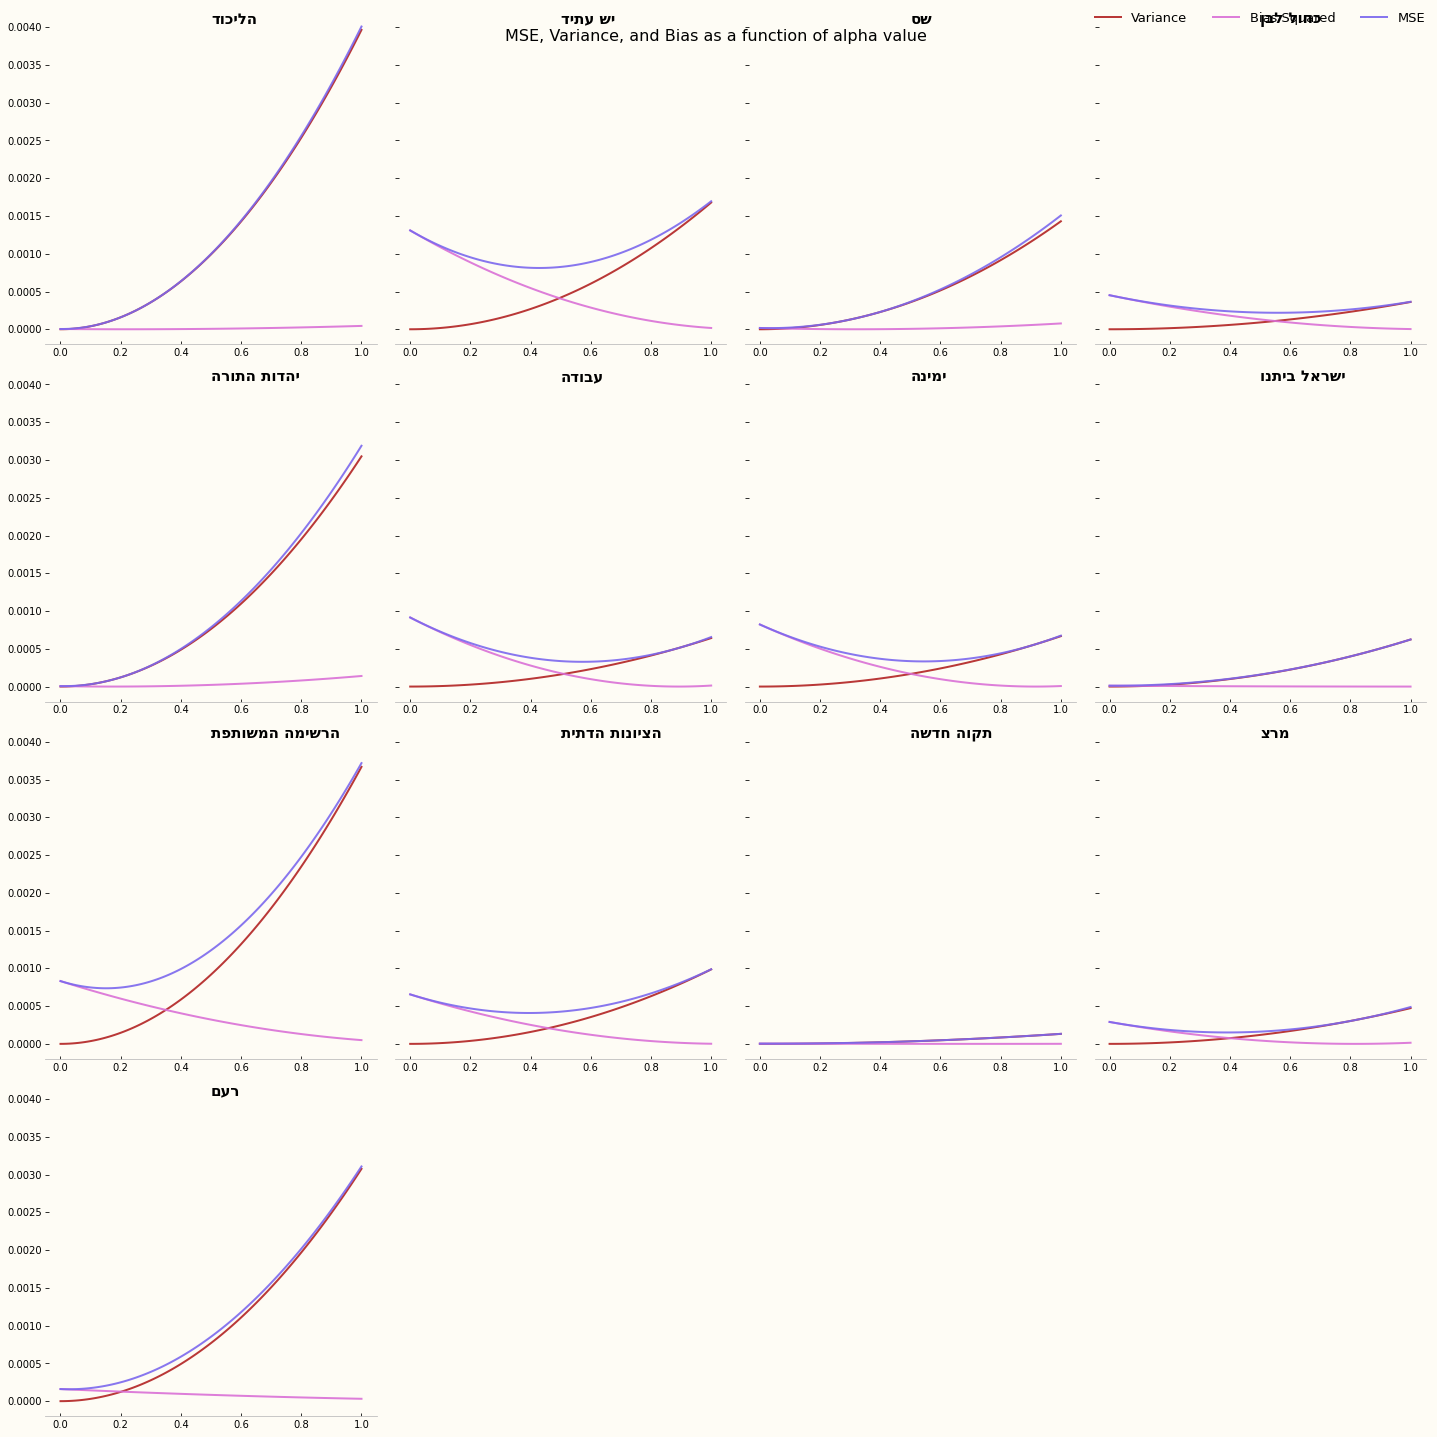

In [ ]:
fig, axs = plt.subplots(4,4, sharey=True)
fig.set_size_inches(20,20)
fig.set_facecolor("#fefcf5")
fig.suptitle("MSE, Variance, and Bias as a function of alpha value", fontsize=16)
for i, ax in enumerate(np.ravel(axs)):
  if i < 13:
    create_line_plot(ax, np.linspace(0,1,101), var_mat[:, i], bias_mat[:, i], names[i])
    handles, labels = ax.get_legend_handles_labels()
  else:
    ax.set_axis_off() 
fig.tight_layout()
fig.legend(handles, labels, loc='upper right', fontsize=13, 
           facecolor="#fefcf5", frameon=False, ncol=3)

### b.

In [ ]:
## The analytical solution for the MSE derivation with respect to alpha.
def analytical_min_alpha(prior,real, var):
  prior_real_diff_sqrd =  (prior - real)**2
  return prior_real_diff_sqrd/(prior_real_diff_sqrd + var)

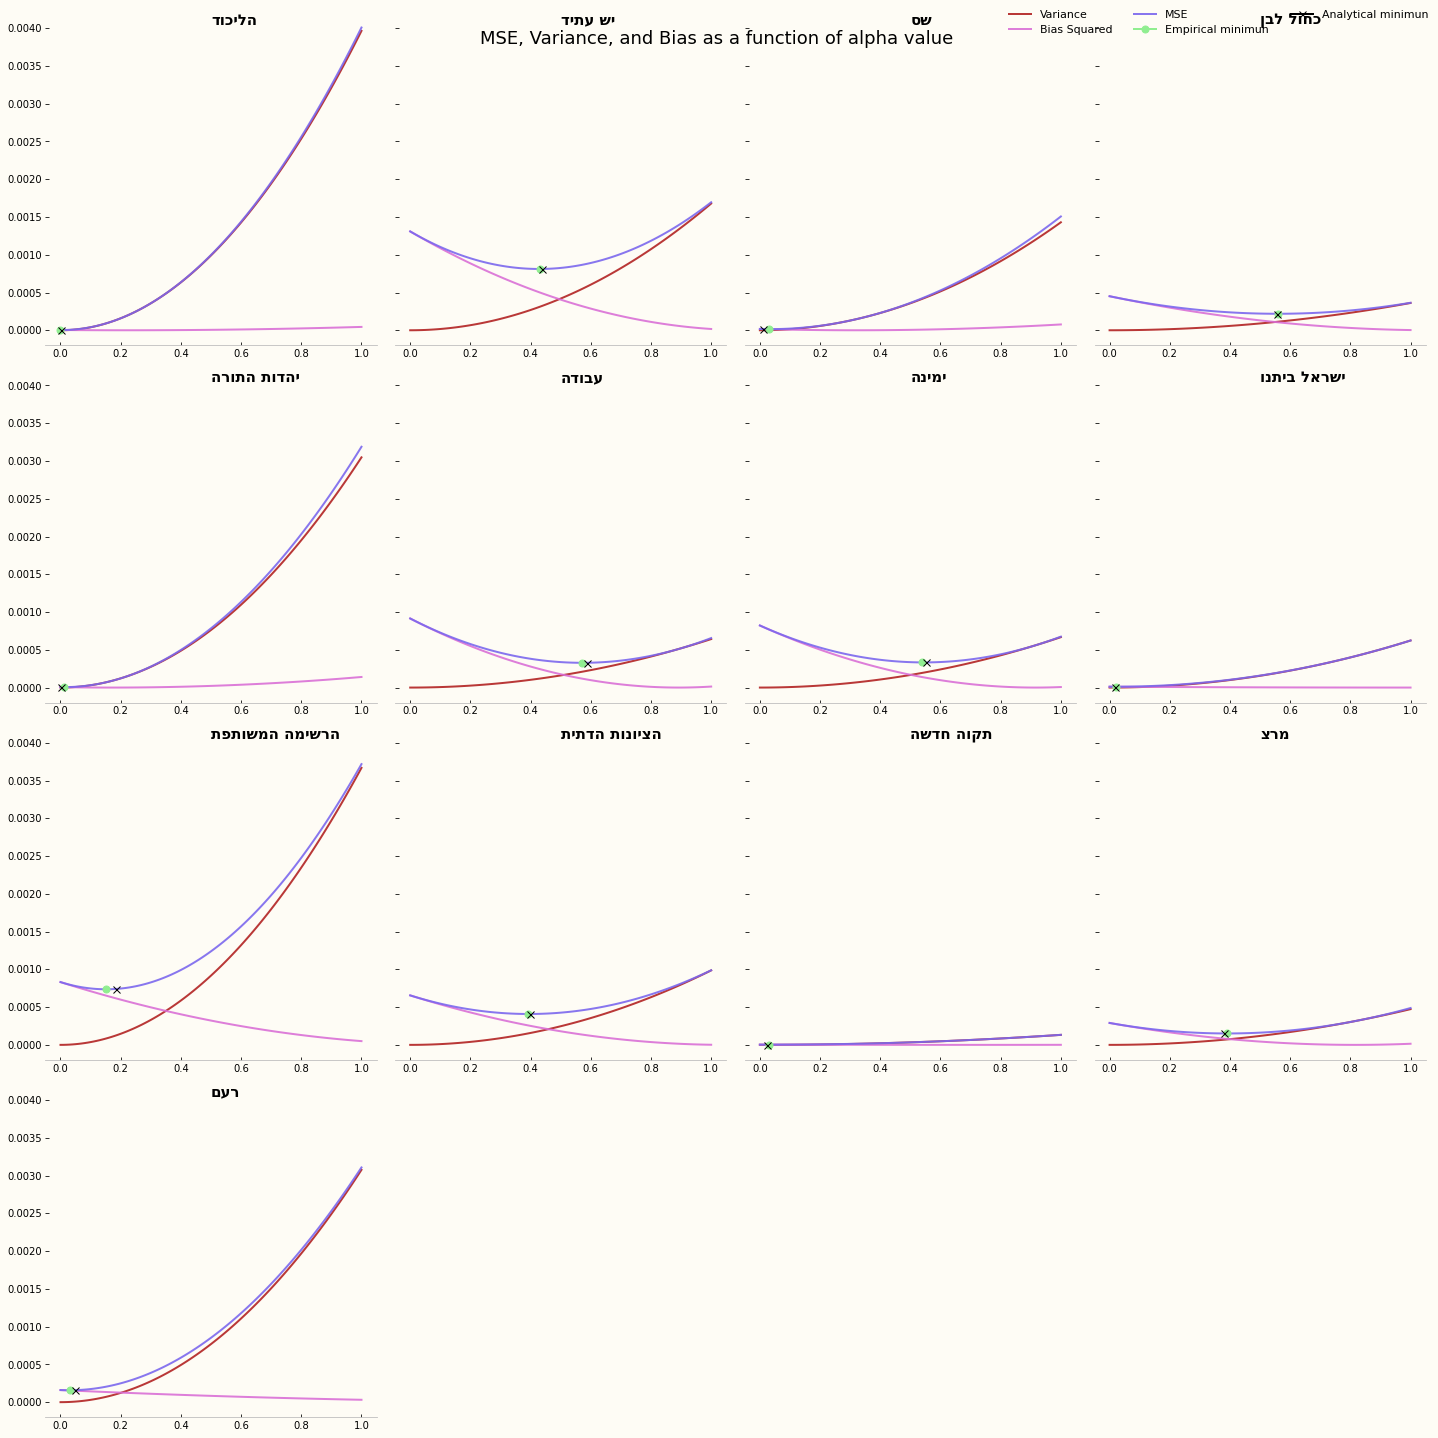

In [ ]:
fig, axs = plt.subplots(4,4, sharey=True)
fig.set_size_inches(20,20)
fig.set_facecolor("#fefcf5")
fig.suptitle("MSE, Variance, and Bias as a function of alpha value", fontsize=18)
for i, ax in enumerate(np.ravel(axs)):
  if i < 13:
    min_alpha = analytical_min_alpha(prior_p[i], real_p[i],p_hat_var[i])
    create_line_plot(ax, np.linspace(0,1,101), var_mat[:, i], bias_mat[:, i], names[i], minimun_point=min_alpha)
    handles, labels = ax.get_legend_handles_labels()
  else:
    ax.set_axis_off() 
fig.legend(handles, labels, loc='upper right', fontsize=11, 
           facecolor="#fefcf5", frameon=False, ncol=3)
fig.tight_layout()

We can clearly see the bias/variance trade off in the plots above. Further more, we can see how controlling alpha value effects diffrently across diffrent parties. As derived analytically in class, we can see as well here that for most of them, picking $ 0 < \alpha < 1$ will achieve lower MSE error.

### c.

In [ ]:
mse_alpha_05 = var_mat[50, :] + bias_mat[50, :]
mse_alpha_1 = var_mat[-1, :] + bias_mat[-1, :]
mse_compare_df = pd.DataFrame()
mse_compare_df["Parties"] = [parties_dict[i] for i in names]
mse_compare_df["alpha_0.5_mse"] = mse_alpha_05
mse_compare_df["alpha_1_mse"] = mse_alpha_1

mse_compare_df

,Parties,alpha_0.5_mse,alpha_1_mse
0,הליכוד,0.0010,0.0040
1,יש עתיד,0.0008,0.0017
2,שס,0.0004,0.0015
3,כחול לבן,0.0002,0.0004
4,יהדות התורה,0.0008,0.0032
5,עבודה,0.0003,0.0007
6,ימינה,0.0003,0.0007
7,ישראל ביתנו,0.0002,0.0006
8,הרשימה המשותפת,0.0012,0.0037
9,הציונות הדתית,0.0004,0.0010


As seen both in the data frame above and the plots, the use of 0.5 value for alpha woould decrease the MSE for all 13 biggest parties in comaprison to alpha 1.
This means that weighting our prior belives (voting share from last election) will make our estimators better for all parties, hence this makes alpha value of 1 to be not applicable as an estimator given the simulation and data we have.
